# Project SKimLit

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-da262bc4-df33-8f0e-a3f5-edda95656e01)


# Getting the Data

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 7.55 MiB/s, done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
# Check Pubmed 20k Files
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [4]:
# start experimenting using the 20 dataset with number replaced with "@" sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign"

In [5]:
# checking the filenames of the directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signtest.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signdev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signtrain.txt']

# Preprocessing the Data

In [6]:
# create a function to read the lines of the file
def get_lines(filename):
  """
  It reads the file from the filepath returns the lines as list in python.
  """
  with open(filename, "r") as f:
    return f.readlines()

In [7]:
train_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt"
train_lines = get_lines(train_dir)
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
len(train_lines)

210040

In [9]:
def preprocess_text(filename):

   """
   Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """

   input_lines = get_lines(filename)
   abstract_lines =""
   abstract_samples = []
   for line in input_lines:
     if line.startswith("###"): # check to see if line is an ID line
       abstract_id = line
       abstract_lines = "" # reset abstract string
     elif line.isspace(): # check to see if line is a new line
       abstract_line_split = abstract_lines.splitlines() # split abstract into separate linesand store them in a list

       for abstract_line_number, abstract_lines in enumerate(abstract_line_split):
         line_data ={}
         target_text_split = abstract_lines.split("\t")
         line_data["target"] = target_text_split[0]
         line_data["text"] = target_text_split[1].lower()
         line_data["line_number"] = abstract_line_number +1
         line_data["total_lines"] = len(abstract_line_split)
         abstract_samples.append(line_data)
     else:
         abstract_lines +=line

   return abstract_samples


In [10]:

# Get data from file and preprocess it
dev_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt"
test_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt"

In [11]:
%%time
train_samples = preprocess_text(train_dir)
val_samples = preprocess_text(dev_dir) # dev is another name for validation set
test_samples = preprocess_text(test_dir)
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 957 ms, sys: 163 ms, total: 1.12 s
Wall time: 2.53 s


(180040, 30212, 180040)

In [12]:
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 1,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 2,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 3,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 4,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [13]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
test_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,1,12
1,METHODS,a total of @ patients with primary knee oa wer...,2,12
2,METHODS,outcome measures included pain reduction and i...,3,12
3,METHODS,pain was assessed using the visual analog pain...,4,12
4,METHODS,secondary outcome measures included the wester...,5,12
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",6,12
6,RESULTS,there was a clinically relevant reduction in t...,7,12
7,RESULTS,the mean difference between treatment arms ( @...,8,12
8,RESULTS,"further , there was a clinically relevant redu...",9,12
9,RESULTS,these differences remained significant at @ we...,10,12


In [14]:
# Distributions in labels
train_df.target.value_counts()


METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<Axes: ylabel='Frequency'>

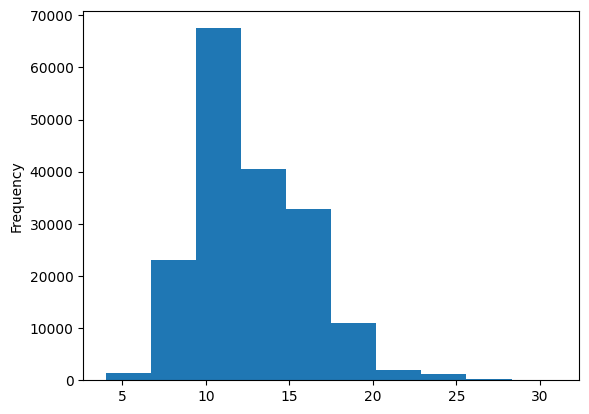

In [15]:
train_df.total_lines.plot(kind='hist')

In [16]:
# Convert the abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 180040)

In [17]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

# Tokenize the sentences

In [18]:

# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what training labels look like
train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [19]:
# Label Encoder
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [20]:

# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# Model 0: Getting a Baseline

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])
model_0.fit(train_sentences, train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [22]:
# Evaluate the validation
model_0.score(X =val_sentences,
              y = val_labels_encoded)

0.7218323844829869

In [23]:

# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [24]:
# Download the Helper Function
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-07-06 11:28:35--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-07-06 11:28:35 (98.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [25]:
# Import calculate_results helper function
from helper_functions import calculate_results

In [26]:

# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [27]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [28]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len # return average sentence length (in tokens)

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <BarContainer object of 20 artists>)

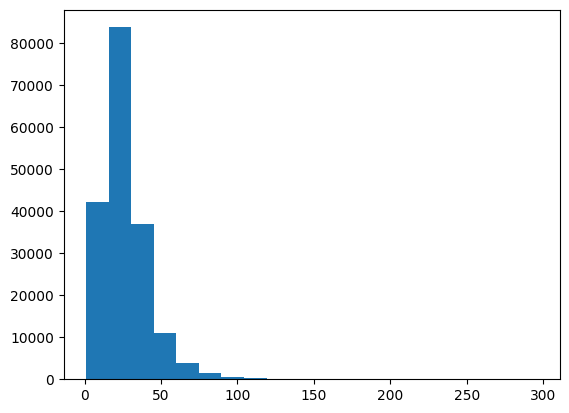

In [29]:
import matplotlib.pyplot as plt
plt.hist(sent_lens,bins=20)

In [30]:
# how long of a sentences length covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens,95))
output_seq_len

55

Create a Vectorizer Layer

In [31]:
# How many words are there in our vocab?(taken from table 2 in)
max_tokens = 68000

In [32]:
# create the text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens = max_tokens,
                                    output_sequence_length = output_seq_len,
                                    )

In [33]:
# Adapt /fit the text vectorizer to training data
text_vectorizer.adapt(train_sentences)

In [34]:
# test
import random
target_sen = random.choice(train_sentences)
print(f"Text:\n{target_sen}")
print(f"\nLength of text:{len(target_sen.split())}")
print(f"\nVecotrized text:{text_vectorizer([target_sen])}")
# it will be till 55

Text:
unique identifier : nct@ .

Length of text:5

Vecotrized text:[[1320  594  176    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [35]:
# how many words in training vocabulary
rct_20k_text = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab:{len(rct_20k_text)}")
print(f"Most Common words in vocab:{(rct_20k_text[:5])}")
print(f"Least Common words in vocab:{(rct_20k_text[-5:])}")

Number of words in vocab:64841
Most Common words in vocab:['', '[UNK]', 'the', 'and', 'of']
Least Common words in vocab:['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [36]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

# Embedding Layer

In [37]:
# create token Embedding Layer
token_embed = layers.Embedding(input_dim = len(rct_20k_text),
                               output_dim =128,
                               mask_zero = True,#this is for the zeroes in vectors
                               name = "token_embedding")

In [38]:
print(f"sentences before vecotrization:{target_sen}\n")
vectorized_sen = text_vectorizer([target_sen])
print(f"Sentences after vectorization:\n{vectorized_sen}\n")
embedded_sen = token_embed(vectorized_sen)
print(f"Sentences after embedding:{embedded_sen}\n")
print(f"Embedded sentences shape:{embedded_sen.shape}")

sentences before vecotrization:unique identifier : nct@ .

Sentences after vectorization:
[[1320  594  176    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentences after embedding:[[[-0.01938143  0.03052422 -0.01155224 ... -0.02155076 -0.03815237
   -0.04888766]
  [ 0.0045855  -0.03265899  0.02582786 ... -0.01979418  0.04062548
    0.03640744]
  [ 0.03667057  0.02706839  0.02865857 ...  0.00731055  0.03692508
    0.01709187]
  ...
  [ 0.04207123 -0.04168059  0.03877104 ... -0.00743093  0.02765627
   -0.04408026]
  [ 0.04207123 -0.04168059  0.03877104 ... -0.00743093  0.02765627
   -0.04408026]
  [ 0.04207123 -0.04168059  0.03877104 ... -0.00743093  0.02765627
   -0.04408026]]]

Embedded sentences shape:(1, 55, 128)


# Create the Dataset (As Fast as Possible)

In [39]:
# better performance using the tf.data API
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [40]:
# Take the Tensorflow datasets and turn them into prefected dataset
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [41]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

# Model 1: Conv1D

In [42]:
from keras.api._v2.keras import activations
# create the 1D conv modek to process sequences
inputs = layers.Input(shape =(1,),dtype = tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64,kernel_size = 5,padding = "same",activation = "relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes,activation = "softmax")(x)
model_1 = tf.keras.Model(inputs,outputs, name ="model_1")

model_1.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325 

In [43]:
# fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch = int(0.1*len(train_dataset)),
                              epochs = 3,
                              validation_data=valid_dataset,
                              validation_steps = int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 43s 60ms/step - loss: 0.9141 - accuracy: 0.6380 - val_loss: 0.6958 - val_accuracy: 0.7317
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.6653 - accuracy: 0.7507 - val_loss: 0.6390 - val_accuracy: 0.7646
Epoch 3/3
562/562 [==============================] - 8s 14ms/step - loss: 0.6230 - accuracy: 0.7716 - val_loss: 0.6023 - val_accuracy: 0.7856


In [44]:
# evaluate the dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.6029 - accuracy: 0.7852


[0.6028928756713867, 0.7851516008377075]

In [45]:
# make prediction
model_1_pred_probs = model_1.predict(valid_dataset)

945/945 [==============================] - 2s 2ms/step


In [46]:
model_1_pred_probs

array([[4.3604580e-01, 1.9016179e-01, 6.5688781e-02, 2.8215116e-01,
        2.5952382e-02],
       [4.4392297e-01, 3.0466190e-01, 1.3426780e-02, 2.2901943e-01,
        8.9689866e-03],
       [1.5873355e-01, 7.8303525e-03, 2.5148110e-03, 8.3089072e-01,
        3.0610838e-05],
       ...,
       [5.9044855e-06, 8.3898462e-04, 8.1670331e-04, 3.4930815e-06,
        9.9833494e-01],
       [5.3990103e-02, 4.5448753e-01, 8.9250937e-02, 7.1885906e-02,
        3.3038554e-01],
       [1.7535754e-01, 6.5804005e-01, 4.7143627e-02, 5.9426602e-02,
        6.0032122e-02]], dtype=float32)

In [47]:
model_1_preds= tf.argmax(model_1_pred_probs,axis =1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [48]:
# calculate the results
model_1_results = calculate_results(val_labels_encoded,
                                    model_1_preds)

In [49]:
model_1_results

{'accuracy': 78.51515953925593,
 'precision': 0.781741250279737,
 'recall': 0.7851515953925593,
 'f1': 0.7824936538998339}

In [50]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

# Ṃodel 2: Feature Extraction with pretrained Feature Extractor

In [51]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [52]:
#test out
random_train_sentence = random.choice(train_sentences)
print(f"Random Sentences:\n{random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentences after embedding:\n{use_embedded_sentence}")
print(f"Length of sentence embeddinf\n{len(use_embedded_sentence)}")

Random Sentences:
the mean operation duration was significantly lower in diathermy group ( p = @ ) .
Sentences after embedding:
[[-2.23099138e-03 -7.36811608e-02  3.03357374e-02 -1.04701659e-02
  -2.86013763e-02 -3.63767631e-02 -4.07147817e-02 -6.51992038e-02
   8.32032040e-03  3.20418961e-02  8.73383582e-02  5.06802974e-03
  -4.92526963e-03  1.86798293e-02  3.00937146e-02 -9.16076917e-03
  -5.45239821e-03  2.14248337e-02  3.99262048e-02 -4.21735272e-02
  -5.85593060e-02 -2.52790451e-02 -1.74859241e-02 -6.42332137e-02
   5.06900670e-03  2.79269889e-02  1.99385602e-02  2.55764369e-02
  -4.66220453e-02  7.92083237e-03  5.40223718e-02  8.24670047e-02
  -4.77538407e-02 -9.98089556e-03 -4.69697304e-02 -7.24247470e-03
   3.55746485e-02 -3.32451649e-02  1.69893389e-03 -4.60684188e-02
   4.89118621e-02  6.45393878e-02  1.56815890e-02  7.40799904e-02
  -2.33256072e-02 -1.84989149e-05  5.88127710e-02  6.11421689e-02
   3.35787758e-02 -3.85191180e-02  6.22202493e-02 -8.70226175e-02
  -1.04843974e

# Building and fitting an NLP feature extraction model from TensorFlow Hub

In [53]:
# Define feature extractor model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding
x = layers.Dense(128, activation="relu")(pretrained_embedding) # add a fully connected layer on top of the embedding
# Note: you could add more layers here if you wanted to
outputs = layers.Dense(5, activation="softmax")(x) # create the output layer
model_2 = tf.keras.Model(inputs=inputs,
                        outputs=outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [54]:
model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [55]:
# Fit feature extractor model for 3 epochs
model_2.fit(train_dataset,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            epochs=3,
            validation_data=valid_dataset,
            validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 11s 15ms/step - loss: 0.9145 - accuracy: 0.6505 - val_loss: 0.7976 - val_accuracy: 0.6865
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7704 - accuracy: 0.7012 - val_loss: 0.7569 - val_accuracy: 0.7055
Epoch 3/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7546 - accuracy: 0.7112 - val_loss: 0.7422 - val_accuracy: 0.7131


In [56]:
# Evaluate the model_2
model_2.evaluate(valid_dataset)

945/945 [==============================] - 10s 11ms/step - loss: 0.7440 - accuracy: 0.7121


[0.7440338134765625, 0.7120680809020996]

In [57]:
# lets predict
model_2_preds_probs = model_2.predict(valid_dataset)

945/945 [==============================] - 10s 11ms/step


In [58]:
model_2_preds_probs

array([[0.4327616 , 0.36924905, 0.00282005, 0.18615125, 0.00901809],
       [0.311206  , 0.54982245, 0.00328845, 0.13264658, 0.00303655],
       [0.22317976, 0.13611169, 0.02241137, 0.57809263, 0.04020449],
       ...,
       [0.00206569, 0.00579476, 0.06139789, 0.00113432, 0.9296073 ],
       [0.00347604, 0.04689911, 0.21244252, 0.00121989, 0.7359625 ],
       [0.19948964, 0.30210903, 0.4365028 , 0.00702107, 0.05487744]],
      dtype=float32)

In [59]:
# lets convert them to tensors
model_2_preds = tf.argmax(model_2_preds_probs,axis =1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [60]:
# Lets Calculate the sentences
model_2_results = calculate_results(val_labels_encoded,
                                    model_2_preds)

In [61]:
model_2_results

{'accuracy': 71.20680524294983,
 'precision': 0.7130677272556284,
 'recall': 0.7120680524294982,
 'f1': 0.7092670193875042}

In [62]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

# Model 3: Character level Embedding

In [63]:
# Make a function where we can create a character level embedding
def split_char(text):
  return " ".join(list(text))
  # split non-level sequence characters
split_char(random_train_sentence)

't h e   m e a n   o p e r a t i o n   d u r a t i o n   w a s   s i g n i f i c a n t l y   l o w e r   i n   d i a t h e r m y   g r o u p   (   p   =   @   )   .'

In [64]:
" ".join(list(train_sentences[0]))

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [65]:
train_char = [split_char(sentences) for sentences in train_sentences]
valid_char = [split_char(sentences) for sentences in val_sentences]
test_char = [split_char(sentences) for sentences in test_sentences]
train_char

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [66]:
# WHats the average len for the characters
char_lens = [len(sentences)for sentences in train_sentences]
import numpy as np
mean_char_lens = np.mean(char_lens)
mean_char_lens

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

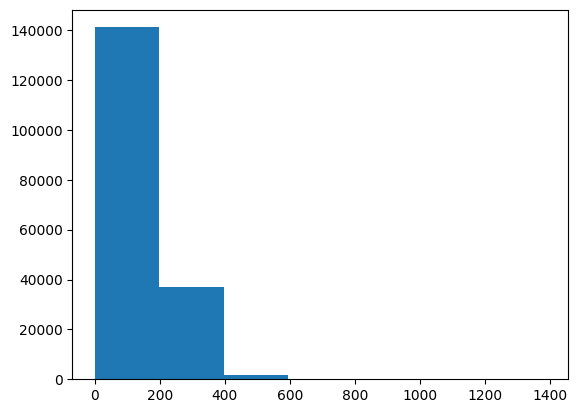

In [67]:
# check the distribution of our sequences at a character level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7)

In [68]:
# Find the character length covers 95% of the sequences
output_len_seq = int(np.percentile(char_lens,95))
output_len_seq

290

In [69]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [70]:
# Create a character-level embedding
NUM_CHAR_TOKENS = len(alphabet) + 2
char_vectorizer = TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                     output_sequence_length = output_len_seq,
                                    # standardize = None, Set when you want to use the punctuation as well
                                     name = "char-vectorizer")

In [71]:
# Adapt characters to training vectorizers
char_vectorizer.adapt(train_char)

In [72]:
# check charater vocab status
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of the different characters:{len(char_vocab)}")
print(f"Number of the most of the alphabets:{char_vocab[:5]}")
print(f"Number of the least number of alphabets:{char_vocab[-5:]}")

Number of the different characters:28
Number of the most of the alphabets:['', '[UNK]', 'e', 't', 'i']
Number of the least number of alphabets:['k', 'x', 'z', 'q', 'j']


In [73]:
# Test out the char-vectorizer
random_train_char = random.choice(train_char)
print(f"Charified text:\n{random_train_char}")
print(f"length of the random char: {len(random_train_char)}")
vectorized_char = char_vectorizer([random_train_char])
print(f"Vectorized Characters:\n{vectorized_char}")
print(f"length of the vectorized char: {len(vectorized_char[0])}")

Charified text:
v a r i o u s   d e v i c e s   h a v e   b e e n   d e v e l o p e d   t o   f a c i l i t a t e   l i v e r   t r a n s e c t i o n   a n d   r e d u c e   b l o o d   l o s s   i n   l i v e r   r e s e c t i o n s   .
length of the random char: 221
Vectorized Characters:
[[21  5  8  4  7 16  9 10  2 21  4 11  2  9 13  5 21  2 22  2  2  6 10  2
  21  2 12  7 14  2 10  3  7 17  5 11  4 12  4  3  5  3  2 12  4 21  2  8
   3  8  5  6  9  2 11  3  4  7  6  5  6 10  8  2 10 16 11  2 22 12  7  7
  10 12  7  9  9  4  6 12  4 21  2  8  8  2  9  2 11  3  4  7  6  9  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  

# Creating the CHaracter level Embedding layer

In [74]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=True, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")

# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_char}\n")
char_embed_example = char_embed(char_vectorizer([random_train_char]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
v a r i o u s   d e v i c e s   h a v e   b e e n   d e v e l o p e d   t o   f a c i l i t a t e   l i v e r   t r a n s e c t i o n   a n d   r e d u c e   b l o o d   l o s s   i n   l i v e r   r e s e c t i o n s   .

Embedded chars (after vectorization and embedding):
[[[ 0.04157969 -0.00130775 -0.03583521 ...  0.00571804  0.03696081
   -0.01484178]
  [ 0.04887874  0.04355422  0.04109946 ... -0.01921537  0.03067968
   -0.00272992]
  [-0.01235756 -0.0433001  -0.04993897 ...  0.01073586  0.02914227
   -0.02247025]
  ...
  [-0.00460136 -0.03586216  0.03079572 ...  0.01679715  0.01302337
   -0.03988604]
  [-0.00460136 -0.03586216  0.03079572 ...  0.01679715  0.01302337
   -0.03988604]
  [-0.00460136 -0.03586216  0.03079572 ...  0.01679715  0.01302337
   -0.03988604]]]

Character embedding shape: (1, 290, 25)


# Model 3 Conv1D with Character Embedding

In [75]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [76]:
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char-vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 5

In [77]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_char, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((valid_char, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [78]:
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 6s 6ms/step - loss: 1.2662 - accuracy: 0.4897 - val_loss: 1.0556 - val_accuracy: 0.5814
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 1.0201 - accuracy: 0.5897 - val_loss: 0.9559 - val_accuracy: 0.6167
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9441 - accuracy: 0.6308 - val_loss: 0.8905 - val_accuracy: 0.6483


In [79]:
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.9067 - accuracy: 0.6471


[0.9067368507385254, 0.647060751914978]

In [80]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 2s 3ms/step


array([[0.10474903, 0.2739569 , 0.21100582, 0.33383462, 0.07645364],
       [0.12551588, 0.7300042 , 0.01038321, 0.06389608, 0.0702006 ],
       [0.05282703, 0.20349252, 0.40350765, 0.20522864, 0.13494417],
       ...,
       [0.05780306, 0.06680287, 0.15765299, 0.05845833, 0.65928274],
       [0.01911739, 0.05635343, 0.35956582, 0.04044737, 0.524516  ],
       [0.3590886 , 0.49534786, 0.07930844, 0.05717274, 0.00908238]],
      dtype=float32)

In [81]:

# Convert predictions to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 1, 2, ..., 4, 4, 1])>

In [82]:
# Calculate Conv1D char only model results
model_3_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_3_preds)
model_3_results

{'accuracy': 64.70607705547464,
 'precision': 0.6454814414272333,
 'recall': 0.6470607705547464,
 'f1': 0.6398676251029971}

# Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

In [83]:

# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(300, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")


In [84]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char-vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

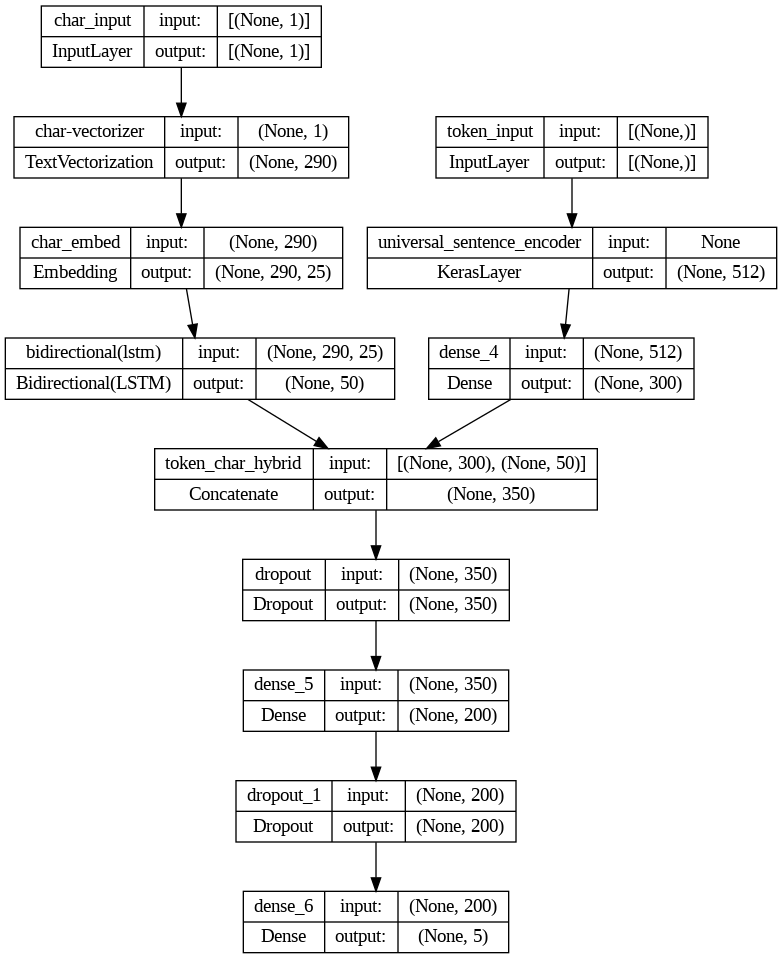

In [85]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4,show_shapes = True)

In [86]:
# Compile the model
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of https://arxiv.org/pdf/1612.05251.pdf mentions using SGD but we'll stick with Adam
                metrics=["accuracy"])

In [87]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_char)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, valid_char))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [88]:
# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset


(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [89]:
# Fitting the model
# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 41s 54ms/step - loss: 0.9186 - accuracy: 0.6416 - val_loss: 0.7450 - val_accuracy: 0.7138
Epoch 2/3
562/562 [==============================] - 27s 49ms/step - loss: 0.7589 - accuracy: 0.7038 - val_loss: 0.6825 - val_accuracy: 0.7380
Epoch 3/3
562/562 [==============================] - 25s 44ms/step - loss: 0.7373 - accuracy: 0.7178 - val_loss: 0.6729 - val_accuracy: 0.7477


In [90]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 19s 20ms/step - loss: 0.6779 - accuracy: 0.7430


[0.6779351830482483, 0.7429829239845276]

In [91]:

# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 28s 26ms/step


array([[5.0713772e-01, 2.4364257e-01, 2.7335221e-03, 2.4228275e-01,
        4.2034029e-03],
       [3.7562436e-01, 4.0434051e-01, 3.6433616e-03, 2.1493135e-01,
        1.4604271e-03],
       [3.2823089e-01, 9.3928635e-02, 4.1638967e-02, 5.1425010e-01,
        2.1951366e-02],
       ...,
       [1.1104236e-03, 8.0753490e-03, 4.7747880e-02, 4.6146114e-04,
        9.4260484e-01],
       [1.0271941e-02, 8.3308823e-02, 2.0746133e-01, 4.3668989e-03,
        6.9459105e-01],
       [4.0304437e-01, 4.7877899e-01, 8.0934964e-02, 2.3400208e-02,
        1.3841452e-02]], dtype=float32)

In [92]:
# Turn prediction probabilities into prediction classes
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [93]:
# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 74.2982920693764,
 'precision': 0.7447112823068754,
 'recall': 0.742982920693764,
 'f1': 0.7425421795075391}

# Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

In [94]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,1,12
1,METHODS,a total of @ patients with primary knee oa wer...,2,12
2,METHODS,outcome measures included pain reduction and i...,3,12
3,METHODS,pain was assessed using the visual analog pain...,4,12
4,METHODS,secondary outcome measures included the wester...,5,12


# Create Positional Embedding

In [97]:
# How many line numbers are there?
train_df["line_number"].value_counts()

1     15000
2     15000
3     15000
4     15000
5     14992
6     14949
7     14758
8     14279
9     13346
10    11981
11    10041
12     7892
13     5853
14     4152
15     2835
16     1861
17     1188
18      751
19      462
20      286
21      162
22      101
23       66
24       33
25       22
26       14
27        7
28        4
29        3
30        1
31        1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

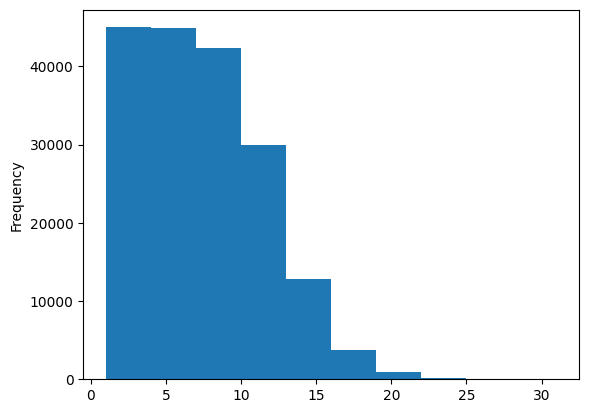

In [98]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

In [100]:
# Use tensorflow for one hot encoding
train_line_number = tf.one_hot(train_df["line_number"].to_numpy(),depth =15)
val_line_number = tf.one_hot(val_df["line_number"].to_numpy(),depth =15)
test_line_number = tf.one_hot(test_df["line_number"].to_numpy(),depth =15)
train_line_number[:10], train_line_number.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

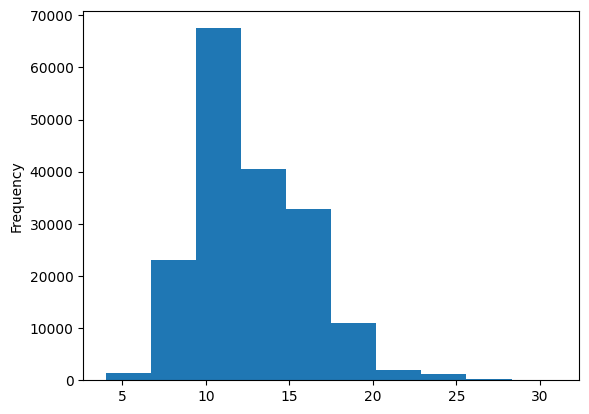

In [101]:
# Check the distribution of total lines
train_df.total_lines.plot.hist();

In [102]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98) # a value of 20 covers 98% of samples

21.0

In [103]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" column
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

# Check shape and samples of total lines one-hot tensor
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

# Tribid Embedding Model

In [112]:
# 1.Token inputs
token_inputs = layers.Input(shape=[],dtype ="string",name="token_inputs")
token_embedding = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128,activation = "relu")(token_embedding)
token_model = tf.keras.Model(inputs = token_inputs,
                             outputs = token_outputs)
# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)
# 3Line number inputs
line_inputs = layers.Input(shape=(15,),dtype =tf.float32,name ="line_inputs")
line_outputs = layers.Dense(32,activation="relu")(line_inputs)
line_model = tf.keras.Model(inputs = line_inputs,
                            outputs = line_outputs)

# 4Total line numbers inputs model
total_line_inputs = layers.Input(shape=(20,),dtype =tf.float32,name ="total_line_inputs")
total_line_outputs = layers.Dense(32,activation="relu")(total_line_inputs)
total_line_model = tf.keras.Model(inputs = total_line_inputs,
                            outputs = total_line_outputs)

# 5. combine 1 and 2 hybrid embedding
combined_embedding = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                             char_model.output])
z = layers.Dense(256,activation = "relu")(combined_embedding)
z = layers.Dropout(0.5)(z)

# 6Combining the positional embedding with 5 tri hybrid
trihybrid_embedding = layers.Concatenate(name="char_token_positional_embedding")([line_model.output,
                                                                                  total_line_model.output,
                                                                                  z])

# 7 create output layer
output_layer =  layers.Dense(5,activation = "softmax",name = "output_layer")(trihybrid_embedding)

# 8. Put together everything
model_5 = tf.keras.Model(inputs =[line_model.input,
                                  total_line_model.input,
                                  token_model.input,
                                  char_model.input],
                         outputs = output_layer)



In [113]:
model_5.summary()

Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char-vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']    

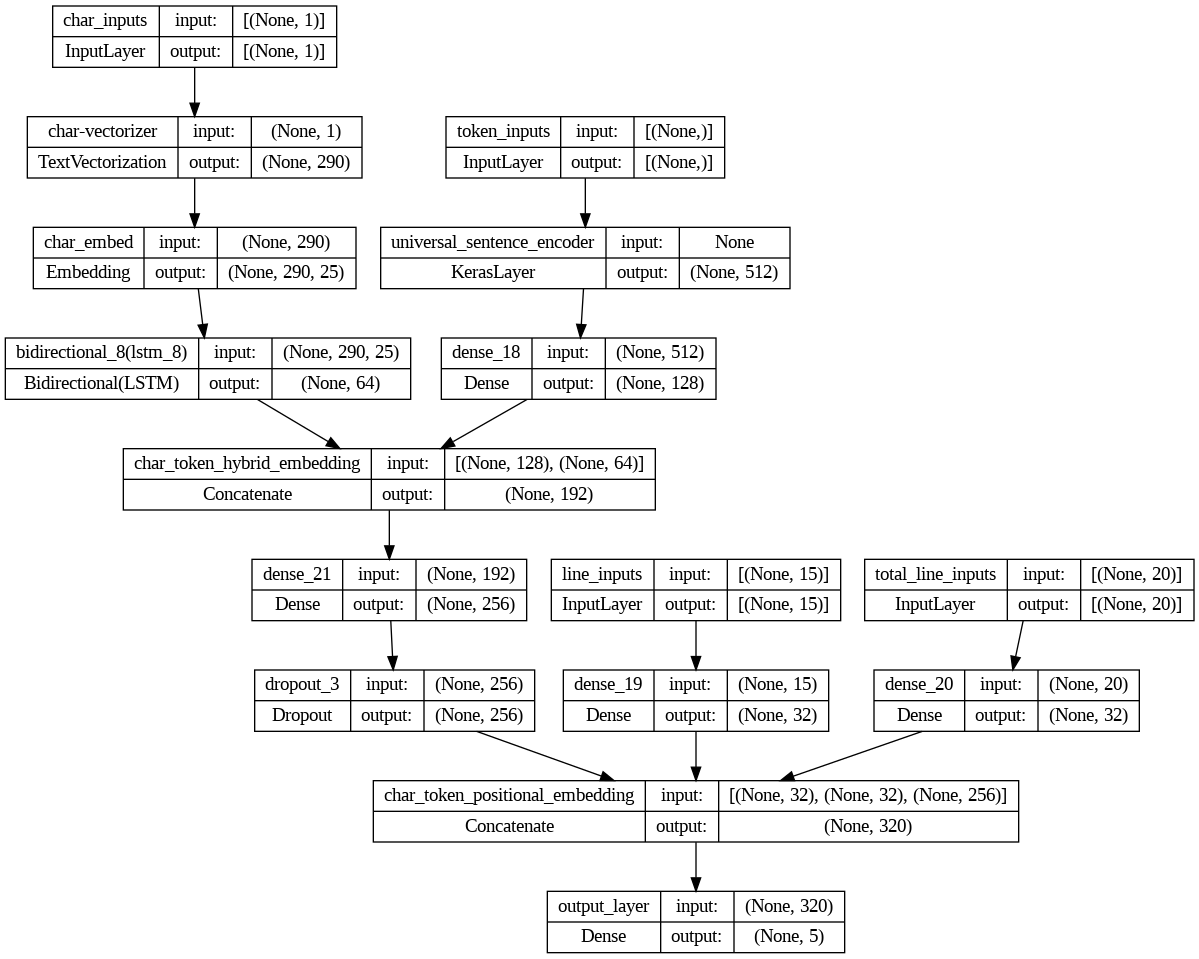

In [116]:
# Plot the token, char, positional embedding model
from tensorflow.keras.utils import plot_model
plot_model(model_5,show_shapes = True)

In [118]:
# compile the model
model_5.compile(loss =tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Create a truhybrid optimizing Dataset

In [121]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_number, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_char)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_number,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              valid_char))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [122]:
# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 43s 54ms/step - loss: 1.0968 - accuracy: 0.7198 - val_loss: 0.9812 - val_accuracy: 0.7992
Epoch 2/3
562/562 [==============================] - 28s 50ms/step - loss: 0.9661 - accuracy: 0.8157 - val_loss: 0.9474 - val_accuracy: 0.8314
Epoch 3/3
562/562 [==============================] - 26s 46ms/step - loss: 0.9497 - accuracy: 0.8240 - val_loss: 0.9401 - val_accuracy: 0.8338


In [125]:
# Evaluate the model
model_5.evaluate(val_pos_char_token_dataset)

945/945 [==============================] - 21s 22ms/step - loss: 0.9381 - accuracy: 0.8322


[0.938090980052948, 0.8321858644485474]

In [126]:
# Make predictions with token-char-positional hybrid model
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 27s 24ms/step


array([[0.5191828 , 0.10508505, 0.00815988, 0.35404968, 0.01352258],
       [0.56407034, 0.10122066, 0.03407433, 0.2927808 , 0.00785386],
       [0.30296683, 0.11675179, 0.12543328, 0.39528385, 0.05956419],
       ...,
       [0.03664512, 0.09839236, 0.04088755, 0.02922295, 0.7948521 ],
       [0.02779599, 0.26665193, 0.0806688 , 0.02724596, 0.5976373 ],
       [0.19110997, 0.66522205, 0.07374207, 0.03555017, 0.03437578]],
      dtype=float32)

In [127]:
# # Turn prediction probabilities into prediction classes
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [128]:
# Calculate results of token-char-positional hybrid model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.2185886402754,
 'precision': 0.8315673847737771,
 'recall': 0.8321858864027539,
 'f1': 0.8312314771800182}

# Compare the model

In [129]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,78.515160,0.781741,0.785152,0.782494
pretrained_token_embed,71.206805,0.713068,0.712068,0.709267
custom_char_embed_conv1d,64.706077,0.645481,0.647061,0.639868
hybrid_char_token_embed,74.298292,0.744711,0.742983,0.742542
tribrid_pos_char_token_embed,83.218589,0.831567,0.832186,0.831231


In [130]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

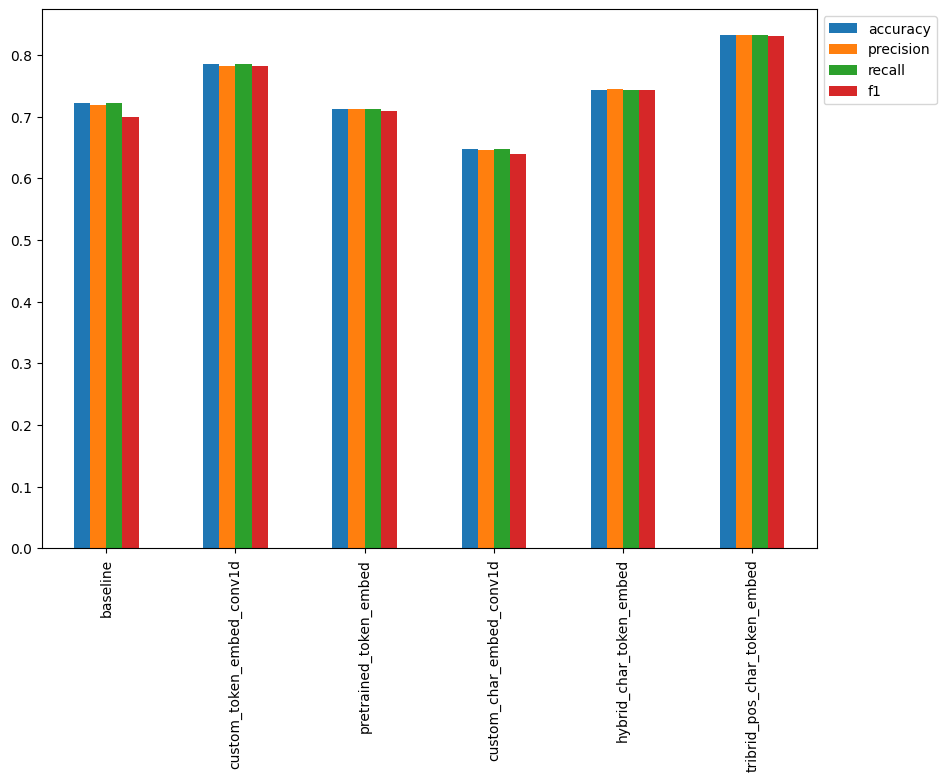

In [131]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

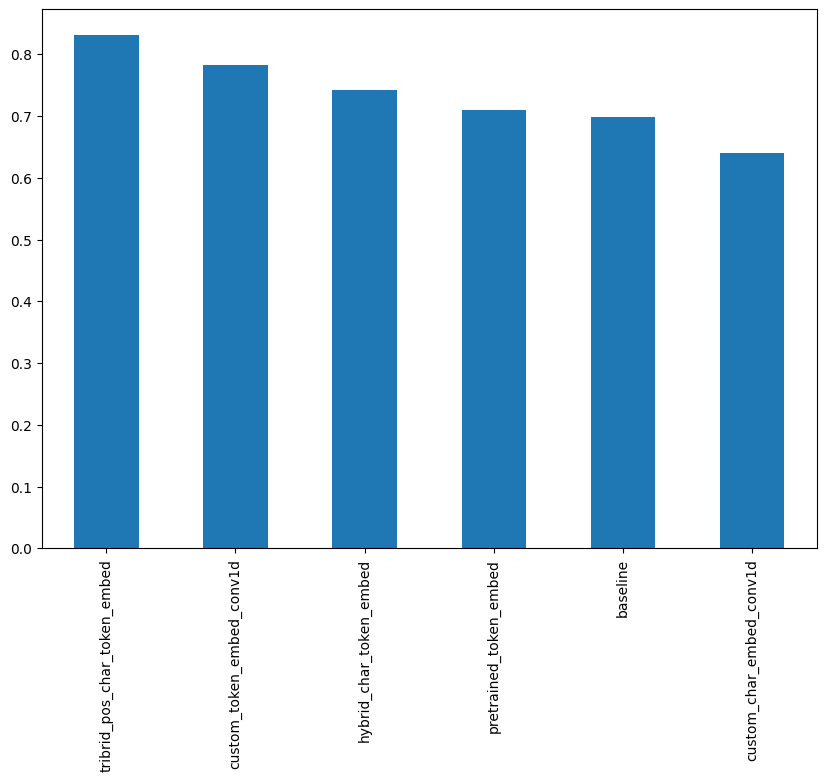

In [132]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

# Save the model

In [133]:
# Save best performing model to SavedModel format (default)
model_5.save("skimlit_tribrid_model") # model will be saved to path specified by string

In [134]:
# Download pretrained model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
!mkdir skimlit_gs_model
!unzip skimlit_tribrid_model.zip -d skimlit_gs_model

--2023-07-06 12:36:16--  https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 108.177.98.128, 74.125.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 962182847 (918M) [application/zip]
Saving to: ‘skimlit_tribrid_model.zip’

skimlit_tribrid_mod 100%[===================>] 917.61M  68.0MB/s    in 17s     

2023-07-06 12:36:32 (55.6 MB/s) - ‘skimlit_tribrid_model.zip’ saved [962182847/962182847]

Archive:  skimlit_tribrid_model.zip
   creating: skimlit_gs_model/skimlit_tribrid_model/
  inflating: skimlit_gs_model/skimlit_tribrid_model/keras_metadata.pb  
   creating: skimlit_gs_model/skimlit_tribrid_model/assets/
 extracting: skimlit_gs_model/skimlit_tribrid_model/fingerprint.pb  
   creating: skimlit_gs_model/skimlit_tribrid_model/variables/
  inflating: skimlit_gs_model/skim

In [135]:
# Import TensorFlow model dependencies (if needed) - https://github.com/tensorflow/tensorflow/issues/38250
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

model_path = "skimlit_gs_model/skimlit_tribrid_model/"

# Load downloaded model from Google Storage
loaded_model = tf.keras.models.load_model(model_path)#,
                                          # Note: with TensorFlow 2.5+ if your SavedModel has a keras_metadata.pb file
                                          # (created when using model.save()), you shouldn't need the custom_objects
                                          # parameter. I'm leaving the code below here in case you do.
                                          # custom_objects={"TextVectorization": TextVectorization, # required for char vectorization
                                          #                 "KerasLayer": hub.KerasLayer}) # required for token embedding

# make the predictions and evaluate them against the rules

In [136]:
# Make predictions with the loaded model on the validation set
loaded_pred_probs = loaded_model.predict(val_pos_char_token_dataset, verbose=1)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

945/945 [==============================] - 21s 20ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [137]:
loaded_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']     

# Evaluate the model

In [140]:
# Create test dataset batch and prefetched
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_number,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_char))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check shapes
test_pos_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [143]:

# Make predictions on the test dataset
test_pred_probs = loaded_model.predict(test_pos_char_token_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

5627/5627 [==============================] - 112s 20ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 2, 2, 2, 2, 2, 4, 4, 4, 4])>

In [144]:
# Evaluate loaded model test predictions
loaded_model_test_results = calculate_results(y_true=test_labels_encoded,
                                              y_pred=test_preds)
loaded_model_test_results


{'accuracy': 81.24750055543213,
 'precision': 0.8114837549688184,
 'recall': 0.8124750055543213,
 'f1': 0.8097236833086899}

# Find the Most wrong

In [145]:
%%time
# Get list of class names of test predictions
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
test_pred_classes

CPU times: user 1min 39s, sys: 4.14 s, total: 1min 44s
Wall time: 1min 41s


['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'BACKGROUND',
 'OBJECTIVE',
 'OBJECTIVE',
 'RESULTS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'RESULTS',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'METHODS',
 'METHODS',
 'METHODS',
 'OBJECTIVE',
 'BACKGROUND',
 'BACKGROUND',
 'OBJECTIVE',
 'RESULTS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'METHODS',
 'CONCLUSIONS',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS'

In [146]:
# Create prediction-enriched test dataframe
test_df["prediction"] = test_pred_classes # create column with test prediction class names
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy() # get the maximum prediction probability
test_df["correct"] = test_df["prediction"] == test_df["target"] # create binary column for whether the prediction is right or not
test_df.head(20)

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,1,12,OBJECTIVE,0.742467,True
1,METHODS,a total of @ patients with primary knee oa wer...,2,12,METHODS,0.678998,True
2,METHODS,outcome measures included pain reduction and i...,3,12,METHODS,0.567256,True
3,METHODS,pain was assessed using the visual analog pain...,4,12,METHODS,0.831000,True
4,METHODS,secondary outcome measures included the wester...,5,12,METHODS,0.797356,True
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",6,12,METHODS,0.475281,True
6,RESULTS,there was a clinically relevant reduction in t...,7,12,RESULTS,0.473809,True
7,RESULTS,the mean difference between treatment arms ( @...,8,12,RESULTS,0.914556,True
8,RESULTS,"further , there was a clinically relevant redu...",9,12,RESULTS,0.711562,True
9,RESULTS,these differences remained significant at @ we...,10,12,RESULTS,0.536606,True


In [147]:
# Find top 100 most wrong samples (note: 100 is an abitrary number, you could go through all of them if you wanted)
top_100_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:100]
top_100_wrong

,target,text,line_number,total_lines,prediction,pred_prob,correct
60188,RESULTS,igf-@ profiles suggest that nnc@-@ may be suit...,13,16,CONCLUSIONS,0.945755,False
163150,RESULTS,the primary outcome was the hamilton rating sc...,5,16,METHODS,0.944501,False
69055,RESULTS,primary outcomes were measured at the end of p...,5,11,METHODS,0.940656,False
92563,METHODS,the ratios of adverse events were @ % and @ % ...,9,10,RESULTS,0.939717,False
95696,BACKGROUND,to test the use of three lead monitoring as a ...,1,12,OBJECTIVE,0.939290,False
...,...,...,...,...,...,...,...
71248,CONCLUSIONS,no parameter showed statistically significant ...,6,10,RESULTS,0.900404,False
19364,METHODS,"if disease activity increases , the dose of ns...",11,18,CONCLUSIONS,0.900370,False
84780,RESULTS,nineteen healthy subjects completed a double-b...,3,12,METHODS,0.900355,False
40865,METHODS,this study provides class iii evidence that ca...,11,11,CONCLUSIONS,0.899811,False


In [148]:
# Investigate top wrong preds
for row in top_100_wrong[0:10].itertuples(): # adjust indexes to view different samples
  _, target, text, line_number, total_lines, prediction, pred_prob, _ = row
  print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}, Line number: {line_number}, Total lines: {total_lines}\n")
  print(f"Text:\n{text}\n")
  print("-----\n")

Target: RESULTS, Pred: CONCLUSIONS, Prob: 0.9457554817199707, Line number: 13, Total lines: 16

Text:
igf-@ profiles suggest that nnc@-@ may be suitable for once-weekly dosing , with a clinically relevant dose @ mg/kg/week .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.9445012807846069, Line number: 5, Total lines: 16

Text:
the primary outcome was the hamilton rating scale for depression ( hdrs ) at end of treatment ( @weeks ) .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.9406561851501465, Line number: 5, Total lines: 11

Text:
primary outcomes were measured at the end of phase i.

-----

Target: METHODS, Pred: RESULTS, Prob: 0.9397174715995789, Line number: 9, Total lines: 10

Text:
the ratios of adverse events were @ % and @ % in tiotropium and ipratropium group , respectively ( p = @ ) .

-----

Target: BACKGROUND, Pred: OBJECTIVE, Prob: 0.9392895698547363, Line number: 1, Total lines: 12

Text:
to test the use of three lead monitoring as a screening tool for atrial fibrilla

# Make Example Prediction

In [149]:
import json
# Download and open example abstracts (copy and pasted from PubMed)
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

with open("skimlit_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)

example_abstracts

--2023-07-06 12:46:58--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2023-07-06 12:46:59 (71.2 MB/s) - ‘skimlit_example_abstracts.json’ saved [6737/6737]



[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

In [150]:
# See what our example abstracts look like
abstracts = pd.DataFrame(example_abstracts)
abstracts


,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


In [151]:
# Create sentencizer - Source: https://spacy.io/usage/linguistic-features#sbd
from spacy.lang.en import English
nlp = English() # setup English sentence parser

# New version of spaCy
sentencizer = nlp.add_pipe("sentencizer") # create sentence splitting pipeline object

# Old version of spaCy
# sentencizer = nlp.create_pipe("sentencizer") # create sentence splitting pipeline object
# nlp.add_pipe(sentencizer) # add sentence splitting pipeline object to sentence parser

# Create "doc" of parsed sequences, change index for a different abstract
doc = nlp(example_abstracts[0]["abstract"])
abstract_lines = [str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type (not spaCy token type)
abstract_lines


['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

In [152]:
# Get total number of lines
total_lines_in_sample = len(abstract_lines)

# Go through each line in abstract and create a list of dictionaries containing features for each line
sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)
sample_lines

[{'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'line_number': 0,
  'total_lines': 7},
 {'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'line_number': 1,
  'total_lines': 7},
 {'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'line_number': 2,
  'total_lines': 7},
 {'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'line_number': 3,
  'total_lines': 7},
 {'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'line_number': 4,
  'total_lines': 7},
 {'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'line_number': 5,
  'total_lines': 7},
 {'text'

In [153]:
# Get all line_number values from sample abstract
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15)
test_abstract_line_numbers_one_hot

<tf.Tensor: shape=(8, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [154]:
# Get all total_lines values from sample abstract
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
test_abstract_total_lines_one_hot

<tf.Tensor: shape=(8, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [156]:
# Split abstract lines into characters
abstract_chars = [split_char(sentence) for sentence in abstract_lines]
abstract_chars

['T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s .',
 'P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 'T r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
 'A   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
 'S i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 

In [160]:

# Make predictions on sample abstract features
%%time
test_abstract_pred_probs = loaded_model.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))
test_abstract_pred_probs

1/1 [==============================] - 3s 3s/step
CPU times: user 1.74 s, sys: 19.5 ms, total: 1.76 s
Wall time: 2.99 s


array([[0.26448247, 0.1105424 , 0.01762423, 0.5750657 , 0.03228524],
       [0.06927066, 0.03808297, 0.7078093 , 0.09543166, 0.08940542],
       [0.13772693, 0.04937519, 0.54679686, 0.16341296, 0.1026881 ],
       [0.09659056, 0.17111637, 0.5257439 , 0.07601643, 0.13053277],
       [0.04459697, 0.08888115, 0.4567545 , 0.04623033, 0.36353707],
       [0.03265215, 0.14626433, 0.51748484, 0.0408832 , 0.2627155 ],
       [0.03290154, 0.17796215, 0.07166822, 0.02870874, 0.6887593 ],
       [0.01843721, 0.1349517 , 0.32084185, 0.03389723, 0.49187204]],
      dtype=float32)

In [163]:
# Turn prediction probabilities into prediction classes
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([3, 2, 2, 2, 2, 2, 4, 4])>

In [165]:
# Turn prediction class integers into string class names
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS']

In [166]:
# Visualize abstract lines and predicted sequence labels
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line}")

OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
METHODS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.


# YAHOOO